In [21]:
import os
import sys
import argparse
import json
import cv2
import csv
import yaml
import math

import numpy as np
from ransac import *
import random

import numpy as np
import matplotlib.pyplot as plt

from shutil import copyfile
from tqdm import tqdm

from scipy.spatial.transform import Rotation as R

### 1. 获取地面点

In [22]:
def load_annotations(label_file):
        pos_list = []
        fieldnames = ['type', 'truncated', 'occluded', 'alpha', 'xmin', 'ymin', 'xmax', 'ymax', 'dh', 'dw',
                      'dl', 'lx', 'ly', 'lz', 'ry']
        with open(label_file, 'r') as csv_file:
            reader = csv.DictReader(csv_file, delimiter=' ', fieldnames=fieldnames)
            for line, row in enumerate(reader):
                pos = [float(row['lx']), float(row['ly']), float(row['lz'])]
                if np.sum(np.array(pos)) < 10e-9:
                    continue
                pos_list.append(pos)
        pos_array = np.array(pos_list)
        return pos_array
    
def augment(xyzs):
    axyz = np.ones((len(xyzs), 4))
    axyz[:, :3] = xyzs
    return axyz

def estimate(xyzs):
    axyz = augment(xyzs[:3])
    return np.linalg.svd(axyz)[-1][-1, :]

def is_inlier(coeffs, xyz, threshold):
    return np.abs(coeffs.dot(augment([xyz]).T)) < threshold

def run_ransac(data, estimate, is_inlier, sample_size, goal_inliers, max_iterations, stop_at_goal=True, random_seed=None):
    best_ic = 0
    best_model = None
    random.seed(random_seed)
    data = list(data)
    for i in range(max_iterations):
        s = random.sample(data, int(sample_size))
        m = estimate(s)
        ic = 0
        for j in range(len(data)):
            if is_inlier(m, data[j]):
                ic += 1
        if ic > best_ic:
            best_ic = ic
            best_model = m
            if ic > goal_inliers and stop_at_goal:
                break
    return best_model, best_ic

def plane_distance(locs, denorm):
    distance_list = []
    for idx in range(locs.shape[0]):
        loc = locs[idx]
        # dis = abs(np.sum(loc * np.array(denorm[:3])) + denorm[3]) / np.sqrt(denorm[0]**2 + denorm[1]**2 + denorm[2]**2)
        
        dis = (np.sum(loc * np.array(denorm[:3])) + denorm[3]) / np.sqrt(denorm[0]**2 + denorm[1]**2 + denorm[2]**2)
        distance_list.append(dis)
    return distance_list

def get_cam2virtual(denorm):
    origin_vector = np.array([0, 1, 0])
    cos_theta =  -1 * denorm[1] / np.sqrt(denorm[1]**2 + denorm[2]**2)
    theta = np.arccos(cos_theta)

    # target_vector = -1 * np.array([denorm[0], denorm[1], denorm[2]])
    target_vector = -1 * np.array([0, denorm[1], denorm[2]])
    target_vector_norm = target_vector / np.sqrt(target_vector[0]**2 + target_vector[1]**2 + target_vector[2]**2)       
    sita = math.acos(np.inner(target_vector_norm, origin_vector))
    n_vector = np.cross(target_vector_norm, origin_vector) 
    n_vector = n_vector / np.sqrt(n_vector[0]**2 + n_vector[1]**2 + n_vector[2]**2)
    n_vector = n_vector.astype(np.float32)
    rot_mat, _ = cv2.Rodrigues(n_vector * sita)
    rot_mat = rot_mat.astype(np.float32)
    return rot_mat, theta

In [23]:
rope3d_root = "/home/yanglei/DataSets/DAIR-V2X/Rope3D"
info_root = os.path.join(rope3d_root, "training")
img_path_list = ["training-image_2a", "training-image_2b", "training-image_2c", "training-image_2d"]

image_path = os.path.join(info_root, "../", "training-image_2a")
label_path = os.path.join(info_root, "label_2")
calib_path = os.path.join(info_root, "calib")
denorm_path = os.path.join(info_root, "denorm")
extrinsics_path = os.path.join(info_root, "extrinsics")

split_txt = os.path.join(info_root, "train.txt")
idx_list = [x.strip() for x in open(split_txt).readlines()]

total_list = []
total_list_fit = []
random.shuffle(idx_list)
for idx in tqdm(idx_list[:3712]):
    extrinsics_file = os.path.join(extrinsics_path, idx + ".yaml")
    image_file = os.path.join(image_path, idx + ".jpg")
    calib_file = os.path.join(calib_path, idx + ".txt")
    denorm_file = os.path.join(denorm_path, idx + ".txt")
    label_file = os.path.join(label_path, idx + ".txt")
    
    # denorm
    with open(denorm_file, 'r') as f:
        lines = f.readlines()
    denorm = np.array([float(item) for item in lines[0].split(' ')])
    
    # annotations
    locs = load_annotations(label_file)
    
    '''
    # line points
    with open(extrinsics_file, 'r', encoding='utf-8') as f:
        extrinsics = yaml.load(f.read(), Loader=yaml.FullLoader)
    translation = extrinsics["transform"]["translation"]
    translation_matrix = np.array([translation['x'], translation['y'], translation['z']]).reshape(3, 1)
    rotation = extrinsics["transform"]["rotation"]
    Rq=[rotation['x'], rotation['y'], rotation['z'], rotation['w']]
    Rm = R.from_quat(Rq)
    rotation_matrix = Rm.as_matrix()
    Tr_world_camera = np.hstack([rotation_matrix, translation_matrix])
    Tr_world_camera = np.vstack([Tr_world_camera, np.array([0, 0, 0, 1.0]).reshape(1, 4)])
    Tr_world_camera = np.linalg.inv(Tr_world_camera)
    
    if "points_lane_detection" not in extrinsics.keys():
        continue
    points_lane = np.array(extrinsics['points_lane_detection']).reshape(-1, 3)
    points_lane_extend = np.hstack([points_lane, np.ones((points_lane.shape[0], 1))])
    points_lane_camera = np.matmul(points_lane_extend, Tr_world_camera.T)
    '''
    with open(calib_file) as f:
        lines = f.readlines()
    obj = lines[0].strip().split(' ')[1:]
    P2 = np.array(obj, dtype=np.float32).reshape(3, 4)
    
    cam2virtual, _ = get_cam2virtual(denorm)
    height_ref = np.abs(denorm[3]) / np.sqrt(denorm[1]**2 + denorm[2]**2)

    h_offsets_list = []
    for idx in range(locs.shape[0]):
        loc = locs[idx]
        loc = loc[:, np.newaxis]
        locs_virtual = np.matmul(cam2virtual, loc)
        h_offset = locs_virtual[1] -  height_ref
        h_offsets_list.append(h_offset)
    '''
    point_lane_image = np.matmul(points_lane_camera, P2.T)
    # fitting ground equation
    n = points_lane_camera.shape[0]
    max_iterations = 5
    goal_inliers = n * 0.5
    xyzs = points_lane_camera[:, :3]
    denorm_fit, b = run_ransac(xyzs, estimate, lambda x, y: is_inlier(x, y, 0.01), 3, goal_inliers, max_iterations)
    '''
    dis_denorm_list = plane_distance(locs, denorm)
    # dis_denorm_fit_list = plane_distance(locs, denorm_fit)
    
    total_list += dis_denorm_list
    # total_list_fit += dis_denorm_fit_list
    
    # visualization
    '''
    depth = point_lane_image[:, 2]
    proj_x = point_lane_image[:, 0] / depth
    proj_y = point_lane_image[:, 1] / depth
    proj_points = np.vstack([proj_x, proj_y]).T
    image = cv2.imread(image_file)
    # draw on images
    for point_idx in range(proj_points.shape[0]):
        point = proj_points[point_idx]
        cv2.circle(image, (int(point[0]), int(point[1])), 3, (255,0,0),-1)
    plt.imshow(image)
    cv2.imwrite("points_lane_image.png", image)
    '''
print(sum(total_list) / len(total_list))
print(sum(total_list_fit) / len(total_list_fit))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3712/3712 [02:23<00:00, 25.86it/s]


0.13295944234750667


ZeroDivisionError: division by zero

In [27]:
h_offsets_array = np.array(h_offsets_list)

In [28]:
np.min(h_offsets_array)

-0.6588710452029565

### 2. 可视化地面点

In [272]:
import plotly.graph_objects as go
import pandas as pd

df_tmp = pd.DataFrame(points_lane_camera[:, :3], columns=["x", "y", "z"])
df_tmp["norm"] = np.sqrt(np.power(df_tmp[["x", "y", "z"]].values, 2).sum(axis=1))
scatter = go.Scatter3d(
    x=df_tmp["x"],
    y=df_tmp["y"],
    z=df_tmp["z"],
    mode="markers",
    marker=dict(size=2, color=df_tmp["norm"], opacity=0.8),
)

df_tmp = pd.DataFrame(locs[:, :3], columns=["x", "y", "z"])
df_tmp["norm"] = np.sqrt(np.power(df_tmp[["x", "y", "z"]].values, 2).sum(axis=1))

scatter1 = go.Scatter3d(
    x=df_tmp["x"],
    y=df_tmp["y"],
    z=df_tmp["z"],
    mode="markers",
    marker=dict(size=5, color=100, opacity=1.0),
)

fig = go.Figure(data=[scatter, scatter1])
fig.update_layout(scene_aspectmode="data")
fig.show()

### 2. 拟合地平面

/home/yanglei/anaconda3/envs/RSU/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



took iterations: 100 best model: [-1.58067355e-05 -1.52565694e-01 -2.68837801e-02  9.87927614e-01] explains: 335
[ 6.24449600e-03 -9.84458100e-01 -1.75508500e-01  6.67366791e+00]


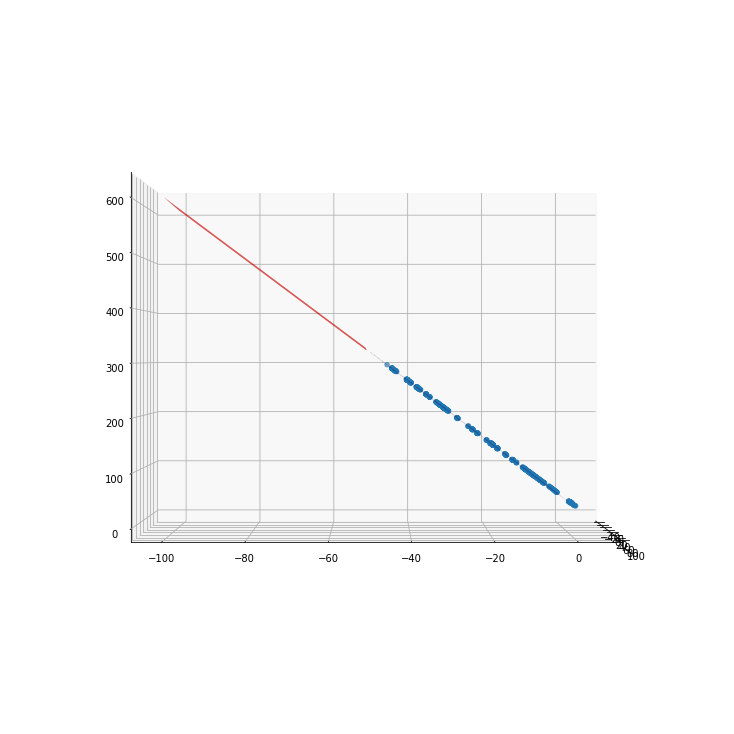

In [273]:
import numpy as np
from ransac import *
import random

def augment(xyzs):
    axyz = np.ones((len(xyzs), 4))
    axyz[:, :3] = xyzs
    return axyz

def estimate(xyzs):
    axyz = augment(xyzs[:3])
    return np.linalg.svd(axyz)[-1][-1, :]

def is_inlier(coeffs, xyz, threshold):
    return np.abs(coeffs.dot(augment([xyz]).T)) < threshold

def run_ransac(data, estimate, is_inlier, sample_size, goal_inliers, max_iterations, stop_at_goal=True, random_seed=None):
    best_ic = 0
    best_model = None
    random.seed(random_seed)
    # random.sample cannot deal with "data" being a numpy array
    data = list(data)
    for i in range(max_iterations):
        s = random.sample(data, int(sample_size))
        m = estimate(s)
        ic = 0
        for j in range(len(data)):
            if is_inlier(m, data[j]):
                ic += 1
        if ic > best_ic:
            best_ic = ic
            best_model = m
            if ic > goal_inliers and stop_at_goal:
                break
    print('took iterations:', i+1, 'best model:', best_model, 'explains:', best_ic)
    return best_model, best_ic

if __name__ == '__main__':
    import matplotlib
    import matplotlib.pyplot as plt
    from mpl_toolkits import mplot3d
    fig = plt.figure(figsize=(10, 10))
    
    ax = mplot3d.Axes3D(fig)

    def plot_plane(a, b, c, d, scale=(-75, -50.0)):
        xx, yy = np.mgrid[:100, scale[0]:scale[1]]
        return xx, yy, (-d - a * xx - b * yy) / c

    n = points_lane_camera.shape[0]
    max_iterations = 100
    goal_inliers = n * 0.8

    # test data
    xyzs = points_lane_camera[:, :3]
    ax.scatter3D(xyzs.T[0], xyzs.T[1], xyzs.T[2])

    # RANSAC
    m, b = run_ransac(xyzs, estimate, lambda x, y: is_inlier(x, y, 0.01), 3, goal_inliers, max_iterations) 
    a, b, c, d = m
    xx, yy, zz = plot_plane(a, b, c, d, (-50, 0))
    ax.plot_surface(xx, yy, zz, color=(1, 0, 0, 1))
    
    a, b, c, d = denorm[0], denorm[1], denorm[2], denorm[3]
    print(denorm)
    xx, yy, zz = plot_plane(a, b, c, d, (-100, -50))
    ax.plot_surface(xx, yy, zz, color=(1, 0, 0, 1))
    
    ax.view_init(elev=0, azim=0)
    plt.show()

In [199]:
np.linalg.pinv(Tr_world_camera)

array([[ 4.72919469e-01, -2.04070348e-01,  8.57147869e-01,
         4.60027745e+05],
       [-8.81103145e-01, -1.07208999e-01,  4.60612070e-01,
         4.40625794e+06],
       [-2.10330057e-03, -9.73068098e-01, -2.30508248e-01,
         2.61894013e+01],
       [-9.01045982e-18, -1.47458813e-16, -2.27456541e-17,
         1.00000000e+00]])